# Transfermarkt 데이터 분석 프로젝트
* Transfermarkt에 등록된 market value top 500 선수의 데이터를 분석
* 분석 목적: 
    1. 선수 가치에 영향을 주는 요인 분석하기
    2. 선수 가치를 예측하는 모델 만들기
* 데이터는 웹 크롤러를 활용하여 수집

# Feature Engineering

In [1]:
import pandas as pd
# 부동소수점 표기 방식 변경
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
# seaborn의 색감 + grid
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import seaborn as sns
import warnings
# 오류 무시
warnings.filterwarnings('ignore')

In [2]:
# seaborn계열 스타일 사용 시 폰트 재설정
plt.rc('font', family='NanumGothic')
plt.rc('font', size=13)

In [3]:
df = pd.read_csv('source/TransferMarket_EDA.csv', index_col=0)

In [4]:
df.head()

,name,age,height,country,position,position-detail,foot,league,team,joined,joined_year,contract expires,contract expires_year,goals,assists,appearances,goals conceded,conbyapp,clean sheets,market value
0,Kylian Mbappé,21,178,France,Forward,Centre-Forward,right,Ligue 1,Paris Saint-Germain,2018-07-01,2018,2022-06-30,2022,30,17,33,0,0.00,0,267274026727.40
1,Raheem Sterling,25,170,England,Forward,Left Winger,right,Premier League,Manchester City,2015-07-14,2015,2023-06-30,2023,20,7,39,0,0.00,0,213819221381.92
2,Neymar,28,175,Brazil,Forward,Left Winger,right,Ligue 1,Paris Saint-Germain,2017-08-03,2017,2022-06-30,2022,18,10,22,0,0.00,0,213819221381.92
3,Sadio Mané,27,174,Senegal,Forward,Left Winger,right,Premier League,Liverpool FC,2016-07-01,2016,2023-06-30,2023,18,12,38,0,0.00,0,200455520045.55
4,Mohamed Salah,27,175,Egypt,Forward,Right Winger,left,Premier League,Liverpool FC,2017-07-01,2017,2023-06-30,2023,20,9,40,0,0.00,0,200455520045.55


### 불필요한 컬럼 제거하기

* country 탈락 - 너무 많은 범주
* position-detail으로 구분 시 샘플이 너무 적음 -> 탈락
* team은 더 포괄적인 league로 대체
* joined와 contract expires 탈락
* goals conceded는 골키퍼 한정 음의 상관관계를 가짐
    * 하지만 골키퍼의 수가 적고, 페널티 처리를 하기에도 애매함
    * 아쉽지만 이런 피처를 어떻게 활용할 수 있을지 추후에 더 공부하기로 하고, 지금은 탈락
* conbyapp도 자연스레 탈락
* goals, assists, clean sheets를 모두 팀 기여라고 가정하여 더하자.

In [5]:
df.drop(['country', 'position-detail', 'team', 'joined', 'joined_year', 'contract expires', 'contract expires_year', 'goals conceded', 'conbyapp'], axis=1, inplace=True)
df

,name,age,height,position,foot,league,goals,assists,appearances,clean sheets,market value
0,Kylian Mbappé,21,178,Forward,right,Ligue 1,30,17,33,0,267274026727.40
1,Raheem Sterling,25,170,Forward,right,Premier League,20,7,39,0,213819221381.92
2,Neymar,28,175,Forward,right,Ligue 1,18,10,22,0,213819221381.92
3,Sadio Mané,27,174,Forward,right,Premier League,18,12,38,0,200455520045.55
4,Mohamed Salah,27,175,Forward,left,Premier League,20,9,40,0,200455520045.55
...,...,...,...,...,...,...,...,...,...,...,...
495,Shoya Nakajima,25,164,Forward,right,Other league,1,3,28,0,26727402672.74
496,Gerard Moreno,27,180,Forward,left,LaLiga,13,4,27,0,26727402672.74
497,Jonny Otto,26,175,Defender,both,Premier League,1,2,38,0,26727402672.74
498,Bernard,27,164,Forward,right,Premier League,3,2,22,0,26727402672.74


In [6]:
df['totalstat'] = df['goals'] + df['assists'] + df['clean sheets']
df.drop(['goals', 'assists', 'clean sheets'], axis=1, inplace=True)
df

,name,age,height,position,foot,league,appearances,market value,totalstat
0,Kylian Mbappé,21,178,Forward,right,Ligue 1,33,267274026727.40,47
1,Raheem Sterling,25,170,Forward,right,Premier League,39,213819221381.92,27
2,Neymar,28,175,Forward,right,Ligue 1,22,213819221381.92,28
3,Sadio Mané,27,174,Forward,right,Premier League,38,200455520045.55,30
4,Mohamed Salah,27,175,Forward,left,Premier League,40,200455520045.55,29
...,...,...,...,...,...,...,...,...,...
495,Shoya Nakajima,25,164,Forward,right,Other league,28,26727402672.74,4
496,Gerard Moreno,27,180,Forward,left,LaLiga,27,26727402672.74,17
497,Jonny Otto,26,175,Defender,both,Premier League,38,26727402672.74,3
498,Bernard,27,164,Forward,right,Premier League,22,26727402672.74,5


In [7]:
df = df[['name', 'age', 'height', 'position', 'foot', 'league', 'appearances', 'totalstat', 'market value']]

### 수치형 데이터 scale 조정
* 데이터들의 스케일을 조정하여 정규분포에 비슷한 분포를 보이도록 해보자.

In [8]:
from scipy import stats
def skew_graph(df, col):
    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.kdeplot(df[col], ax=ax[0])
    ax[0].set_title('{} skew: {:.2f}'.format(col, df[col].skew()))
    stats.probplot(df[col], dist='norm', fit=True, plot=ax[1])
    plt.show();

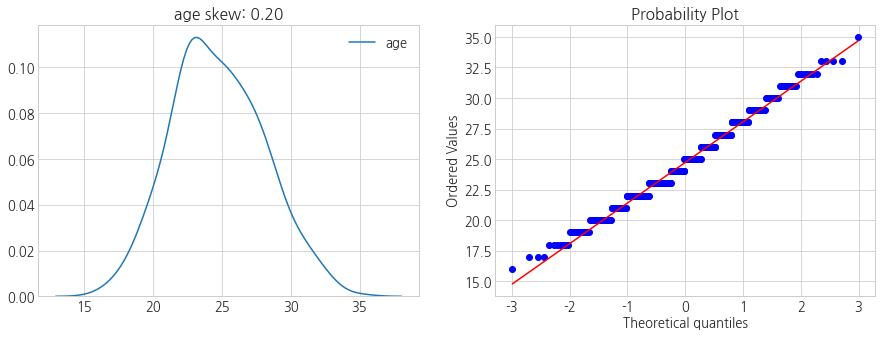

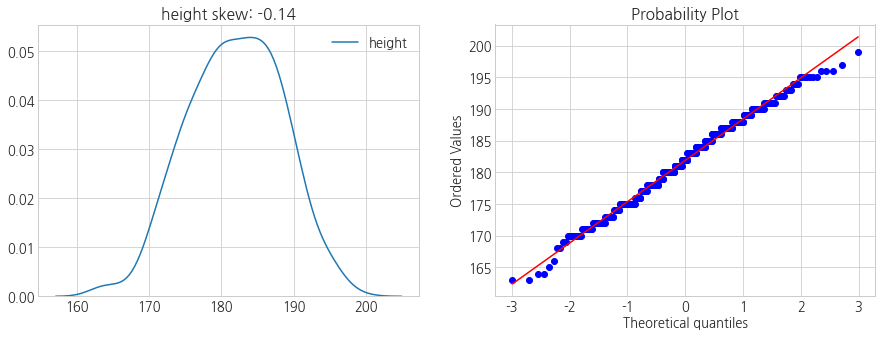

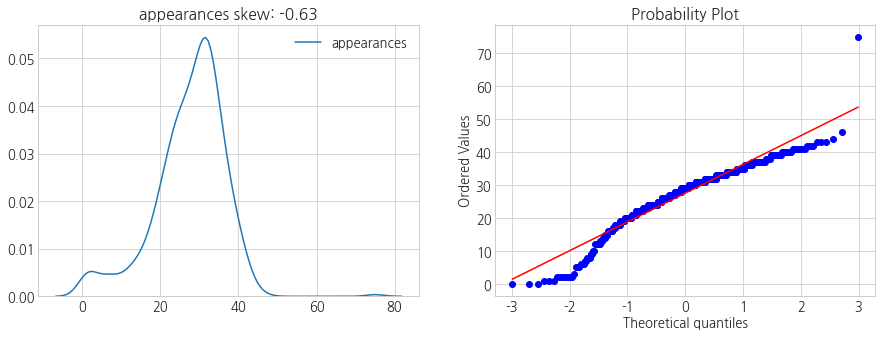

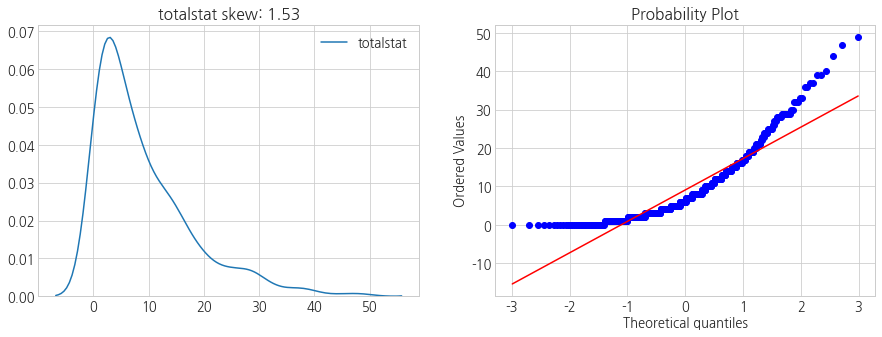

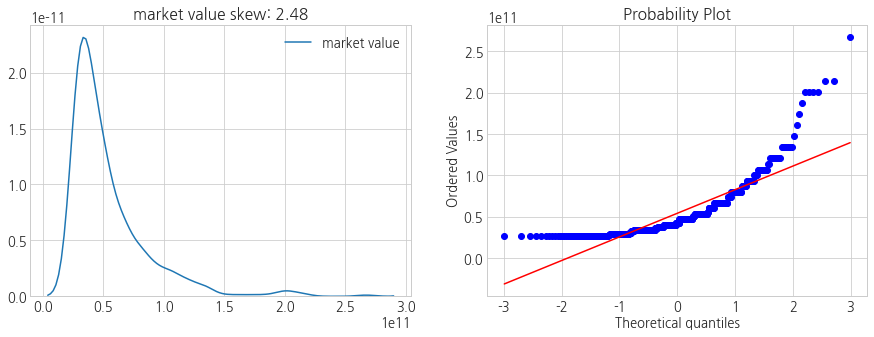

In [9]:
for col in ['age', 'height', 'appearances', 'totalstat', 'market value']:
    skew_graph(df, col)

* totalstat과 market value 컬럼의 스케일을 조정해주어 정규분포에 근사하게 만들어보자.

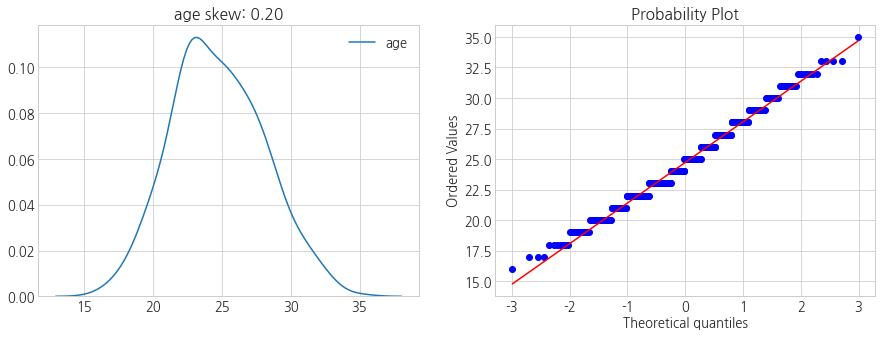

In [10]:
skew_graph(df, 'age')

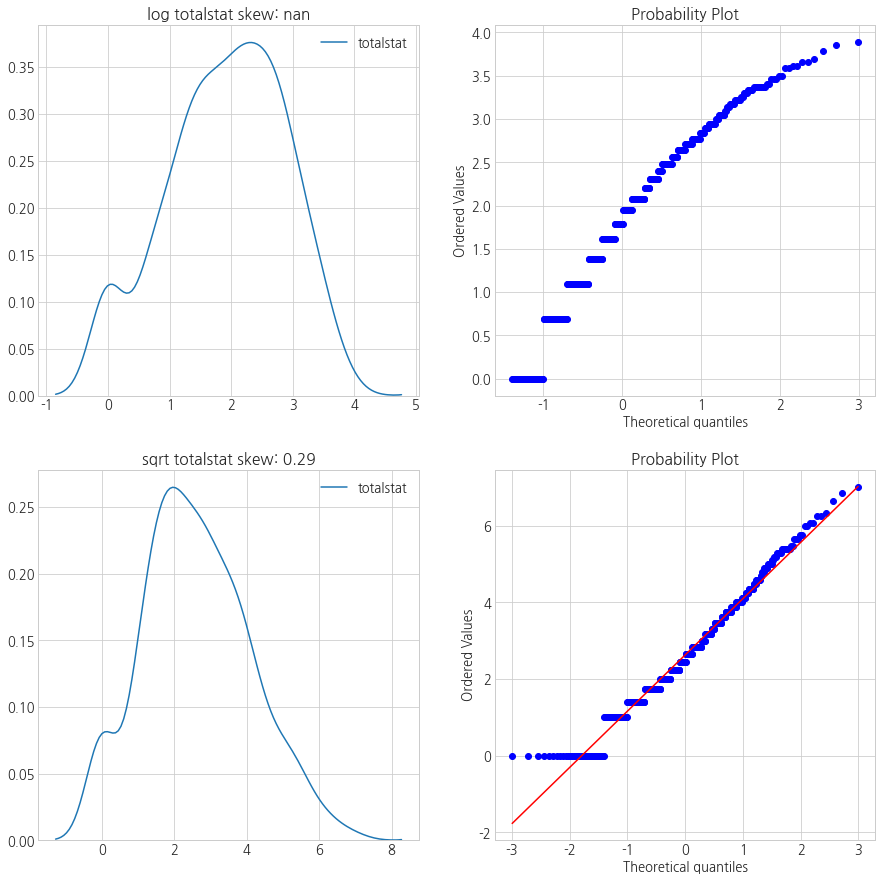

In [11]:
def skew_graph(df, col):
    f, ax = plt.subplots(2, 2, figsize=(15, 15))
    sns.kdeplot(np.log(df[col]+1), ax=ax[0, 0])
    ax[0, 0].set_title('log {} skew: {:.2f}'.format(col, np.log(df[col]).skew()))
    stats.probplot(np.log(df[col]), dist='norm', fit=True, plot=ax[0, 1])
    
    sns.kdeplot(np.sqrt(df[col]), ax=ax[1, 0])
    ax[1, 0].set_title('sqrt {} skew: {:.2f}'.format(col, np.sqrt(df[col]).skew()))
    stats.probplot(np.sqrt(df[col]), dist='norm', fit=True, plot=ax[1, 1])
    plt.show();
skew_graph(df, 'totalstat')

* totalstat은 log변환이 효과적인 것으로 보임

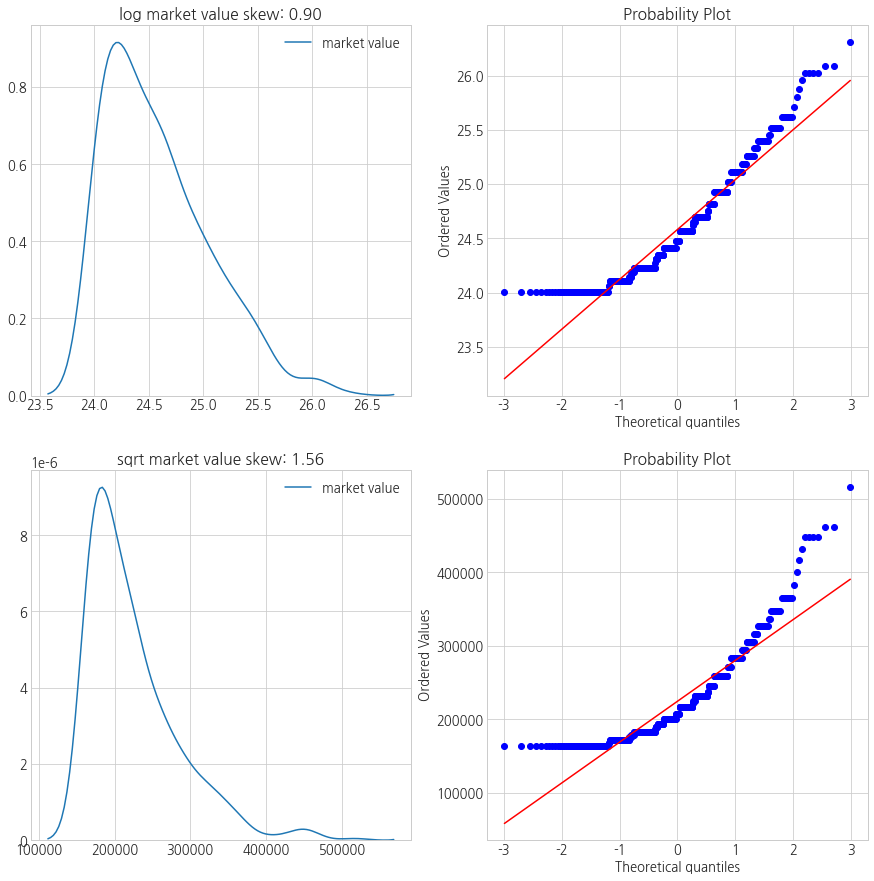

In [12]:
skew_graph(df, 'market value')

* 타겟벡터인 market value는 log나 sqrt 변환을 하더라도 왼쪽으로 치우쳐있다.
* 하지만 원본에 비해서는 더 데이터를 잘 설명하는 것으로 보인다.

In [13]:
df['totalstat_log'] = np.log(df.totalstat+1)

In [14]:
df

,name,age,height,position,foot,league,appearances,totalstat,market value,totalstat_log
0,Kylian Mbappé,21,178,Forward,right,Ligue 1,33,47,267274026727.40,3.87
1,Raheem Sterling,25,170,Forward,right,Premier League,39,27,213819221381.92,3.33
2,Neymar,28,175,Forward,right,Ligue 1,22,28,213819221381.92,3.37
3,Sadio Mané,27,174,Forward,right,Premier League,38,30,200455520045.55,3.43
4,Mohamed Salah,27,175,Forward,left,Premier League,40,29,200455520045.55,3.40
...,...,...,...,...,...,...,...,...,...,...
495,Shoya Nakajima,25,164,Forward,right,Other league,28,4,26727402672.74,1.61
496,Gerard Moreno,27,180,Forward,left,LaLiga,27,17,26727402672.74,2.89
497,Jonny Otto,26,175,Defender,both,Premier League,38,3,26727402672.74,1.39
498,Bernard,27,164,Forward,right,Premier League,22,5,26727402672.74,1.79


In [15]:
# 범주형 데이터에 onehot encoding 진행
df_onehot = pd.get_dummies(df, columns=['position', 'foot', 'league'])

In [16]:
df_onehot

,name,age,height,appearances,totalstat,market value,totalstat_log,position_Defender,position_Forward,position_Goalkeeper,position_Midfielder,foot_both,foot_left,foot_right,league_Bundesliga,league_LaLiga,league_Ligue 1,league_Other league,league_Premier League,league_Serie A
0,Kylian Mbappé,21,178,33,47,267274026727.40,3.87,0,1,0,0,0,0,1,0,0,1,0,0,0
1,Raheem Sterling,25,170,39,27,213819221381.92,3.33,0,1,0,0,0,0,1,0,0,0,0,1,0
2,Neymar,28,175,22,28,213819221381.92,3.37,0,1,0,0,0,0,1,0,0,1,0,0,0
3,Sadio Mané,27,174,38,30,200455520045.55,3.43,0,1,0,0,0,0,1,0,0,0,0,1,0
4,Mohamed Salah,27,175,40,29,200455520045.55,3.40,0,1,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Shoya Nakajima,25,164,28,4,26727402672.74,1.61,0,1,0,0,0,0,1,0,0,0,1,0,0
496,Gerard Moreno,27,180,27,17,26727402672.74,2.89,0,1,0,0,0,1,0,0,1,0,0,0,0
497,Jonny Otto,26,175,38,3,26727402672.74,1.39,1,0,0,0,1,0,0,0,0,0,0,1,0
498,Bernard,27,164,22,5,26727402672.74,1.79,0,1,0,0,0,0,1,0,0,0,0,1,0


In [17]:
X = df_onehot.drop(['name', 'totalstat', 'market value'], axis=1)
y = np.log(df_onehot['market value']+1)

# Modeling

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
logreg = LinearRegression()
scores = cross_val_score(logreg, X, y, cv=10)
print('교차 검증 점수: {}'.format(scores))
print('교차 검증 평균 점수: {}'.format(np.mean(scores)))

교차 검증 점수: [ -15.67680355  -33.19908379  -31.41024855  -48.1579996   -41.30976593
  -72.1027714   -35.55109177 -178.62474811 -224.06864985    0.        ]
교차 검증 평균 점수: -68.01011625502726


In [39]:
from sklearn.linear_model import Ridge
logreg = Ridge(alpha=100)
scores = cross_val_score(logreg, X, y, cv=10)
print('교차 검증 점수: {}'.format(scores))
print('교차 검증 평균 점수: {}'.format(np.mean(scores)))

교차 검증 점수: [ -16.25449637  -34.86825687  -30.66534258  -34.94276982  -20.12398142
  -65.124433    -33.19160133 -187.89481753 -225.86795448    0.        ]
교차 검증 평균 점수: -64.89336533820611


In [58]:
from sklearn.svm import SVR
logreg = SVR(C=0.01, gamma=100)
scores = cross_val_score(logreg, X, y, cv=10)
print('교차 검증 점수: {}'.format(scores))
print('교차 검증 평균 점수: {}'.format(np.mean(scores)))

교차 검증 점수: [ -18.62582659  -51.48819488  -54.15231483  -54.77947779  -10.78134194
   -3.76396542  -24.99305069 -109.38212239 -166.46376689    0.        ]
교차 검증 평균 점수: -49.44300614147615


In [54]:
from sklearn.ensemble import RandomForestRegressor
logreg = RandomForestRegressor()
scores = cross_val_score(logreg, X, y, cv=10)
print('교차 검증 점수: {}'.format(scores))
print('교차 검증 평균 점수: {}'.format(np.mean(scores)))

교차 검증 점수: [ -14.48937443  -40.8045818   -47.15678082  -59.96046151  -60.56465703
  -73.14686068  -44.93781674 -155.29916207 -246.82016837    0.        ]
교차 검증 평균 점수: -74.31798634681884


- - - -
# 결과 및 느낀점, 배운점

* 모델 성능이 모두 매우 좋지 않다.
    * 가장 큰 원인으로는, stat으로 기재할 수 있는 데이터가 득점, 도움, 클린시트 등 밖에 없었기 때문이다.
    * opta와 같은 유료 사이트에서는 키패스, 뛴거리 등이 나오지만, transfermarkt에서는 제공되지 않았다.
* 실제로 내가 관심있는 데이터를 크롤링-모델링까지 모두 직접 해 본 경험을 얻었다.
* 전처리 비중이 70%는 차지한 것 같다.
    * 단순히 데이터를 클리닝하는 작업 외에도, 누락된 데이터를 계속 찾아봐야했고, 잘못 크롤링된 데이터를 수정해야했다.
    * 캐글이나 공모전에서는 이런 과정이 사실 적은데, 실무에서는 아마 전처리 비중이 더 높을것이다.
    * 전처리에 교과서는 없지만, 계속 하다보면 나만의 노하우가 생길 것 같다.
        * 그 와중에도 도메인 지식은 필수지만.
* 어쩌면 garbage in garbage out을 직접 체감한 프로젝트가 아닐 지 생각해본다 